In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
device

c:\Users\TYC\Desktop\python code\hugging face\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [ ]:
#load bedroom->wikiart model
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

#sample some images
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)



c:\Users\TYC\Desktop\python code\hugging face\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\TYC\.cache\huggingface\hub\models--johnowhitaker--sd-class-wikiart-from-bedrooms. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 22.99it

40it [02:20,  3.52s/it]


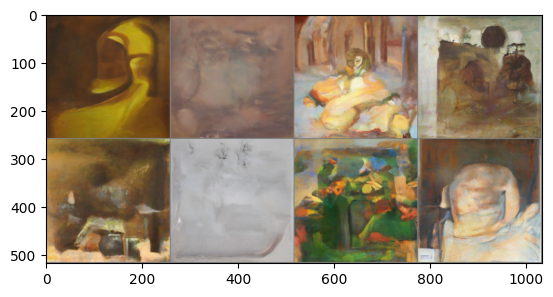

In [7]:
#random noise images
x = torch.randn(8, 3, 256, 256).to(device)

#sampling loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)

    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    x = scheduler.step(noise_pred, t, x).prev_sample

#result
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

In [9]:
#guidance by colour (loss function)
def colour_loss(images, target_color=(0.1, 0.9, 0.5)): #teal colour
     
     target = torch.tensor(target_color).to(images.device) * 2 - 1 #map color to (-1, 1)
     target = target[None, :, None, None] #shape to (b, c, h, w) 
     error = torch.abs(images - target).mean()

     return error

0it [00:00, ?it/s]

1it [00:03,  3.99s/it]

0 loss: 31.709983825683594


11it [00:39,  3.61s/it]

10 loss: 13.149625778198242


21it [01:16,  3.60s/it]

20 loss: 12.806827545166016


31it [01:52,  3.61s/it]

30 loss: 12.916916847229004


40it [02:24,  3.61s/it]
C:\Users\TYC\AppData\Local\Temp\ipykernel_12540\398238148.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  Image.fromarray(np.array(im * 255).astype(np.uint8))


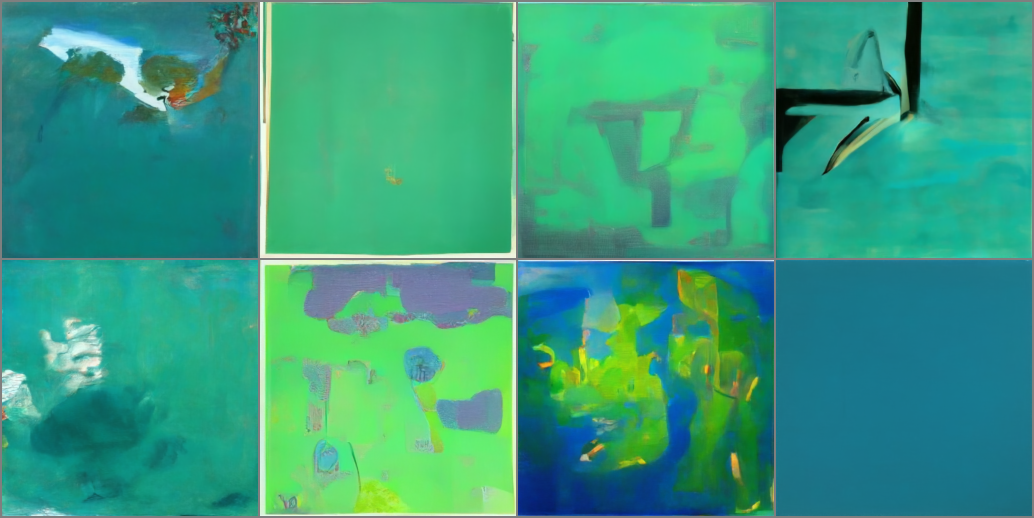

In [ ]:
#guidance scale controls the strength of the effect
guidance_loss_scale = 40

x = torch.randn(8, 3, 256, 256).to(device)

#sampling loop with guidance
for i, t in tqdm(enumerate(scheduler.timesteps)):

    #prepare model
    model_input = scheduler.scale_model_input(x, t)

    #noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    #set x.requires_grad to true
    x = x.detach().requires_grad_()

    #prediction of x0
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    #loss for colour (guidance by teal colour)
    loss = colour_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    #get gradient wrt x
    cond_grad = -torch.autograd.grad(loss, x)[0]

    #modify x
    x = x.detach() + cond_grad

    #step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample

#output
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))



0it [00:00, ?it/s]

0 loss 30.16118049621582


11it [03:31, 19.58s/it]

10 loss 21.558490753173828


21it [06:46, 19.44s/it]

20 loss 20.246044158935547


31it [10:02, 19.60s/it]

30 loss 20.45040512084961


40it [12:58, 19.46s/it]
C:\Users\TYC\AppData\Local\Temp\ipykernel_12540\1593428953.py:32: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  Image.fromarray(np.array(im * 255).astype(np.uint8))


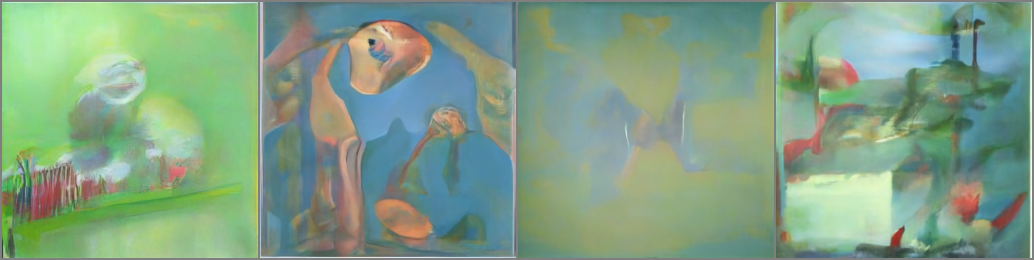

In [12]:
#more accurate mean to guide
guidance_loss_scale = 40
x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    #set requires_grad before forward pass
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)

    #predict
    noise_pred = image_pipe.unet(model_input, t)["sample"]

    #final pred x0
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    #loss colour guidance
    loss = colour_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss", loss.item())

    #gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    #update x
    x = x.detach() + cond_grad

    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

In [21]:
#guidance by CLIP
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai") #import openai ViT CLIP model
clip_model.to(device)

#resize and augment image to match CLIP's training data
tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomAffine(5), #augmentation, eg: skewing /  rotation
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.Normalize(
            mean=(0.4814566, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
            ),
        
    ]
)

c:\Users\TYC\Desktop\python code\hugging face\.venv\Lib\site-packages\open_clip\factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


In [22]:
#loss that embeds image and compare with text features of prompt
def clip_loss(image, text_features):
    image_features = clip_model.encode_image(tfms(image))
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) #square great circle distance

    return dists.mean()


1it [00:04,  4.74s/it]

Steps: 0 Guidance loss: 7.25650691986084


11it [00:52,  4.73s/it]

Steps: 10 Guidance loss: 6.850406646728516


21it [01:39,  4.73s/it]

Steps: 20 Guidance loss: 6.806588649749756


31it [02:26,  4.73s/it]

Steps: 30 Guidance loss: 6.956449031829834


41it [03:14,  4.73s/it]

Steps: 40 Guidance loss: 6.9618659019470215


51it [04:01,  4.74s/it]

Steps: 50 Guidance loss: 6.883333206176758


60it [04:44,  4.73s/it]
C:\Users\TYC\AppData\Local\Temp\ipykernel_12540\2652700613.py:55: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  Image.fromarray(np.array(im * 255).astype(np.uint8))


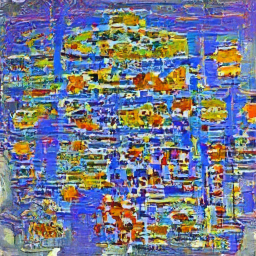

In [25]:
#prompt
prompt = "blue bed with a bear"

guidance_scale = 8
n_cuts = 4 #update gradient every 4 steps

#more steps can let the guidance have more effect
scheduler.set_timesteps(60)

#embedding via CLIP
text = open_clip.tokenize([prompt]).to(device)

with torch.no_grad(), torch.amp.autocast('cuda'):
    text_features = clip_model.encode_text(text)

x = torch.randn(1, 3, 256, 256).to(device)

#sampling loop
for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    #predict
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0

    for cut in range(n_cuts):

        #require grad
        x = x.detach().requires_grad_()

        #x0 pred
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        #loss
        loss = clip_loss(x0, text_features) * guidance_scale

        #gradient
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 10 == 0:
        print("Steps:", i, "Guidance loss:", loss.item())

    #modify x
    alpha_bar = scheduler.alphas_cumprod[i]
    x = x.detach() + cond_grad * alpha_bar.sqrt() #additional scaling factor 

    #step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

Text(0.5, 1.0, 'Possible guidance scaling schedules')

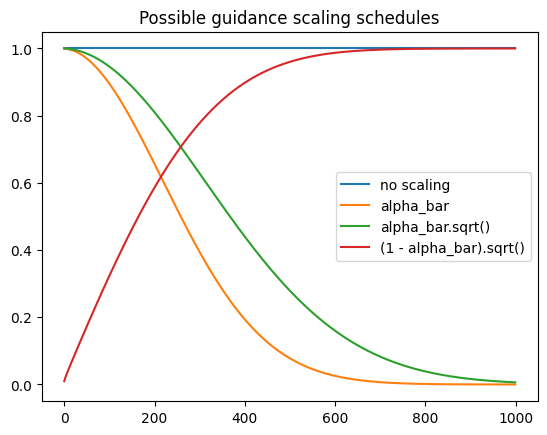

In [ ]:
#additional scaling (alpha_bar.sqrt()) decision
plt.plot([1 for a in scheduler.alphas_cumprod], label="no scaling")
plt.plot([a for a in scheduler.alphas_cumprod], label="alpha_bar")
plt.plot([a.sqrt() for a in scheduler.alphas_cumprod], label = "alpha_bar.sqrt()") #chosen effect maximum at start then decrease
plt.plot([(1 - a).sqrt() for a in scheduler.alphas_cumprod], label="(1 - alpha_bar).sqrt()")
plt.legend()
plt.title("Possible guidance scaling schedules")

In [28]:
#using gradio to visualise (guide by colour loss only)
import gradio as gr
from PIL import Image, ImageColor

def generate(color, guidance_loss_scale):
    target_color = ImageColor.getcolor(color, "RGB")  # Target color as RGB

    target_color = [a / 255 for a in target_color]  # Rescale from (0, 255) to (0, 1)
    x = torch.randn(1, 3, 256, 256).to(device)

    for i, t in tqdm(enumerate(scheduler.timesteps)):
        model_input = scheduler.scale_model_input(x, t)

        with torch.no_grad():
            noise_pred = image_pipe.unet(model_input, t)["sample"]

        x = x.detach().requires_grad_()

        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        loss = colour_loss(x0, target_color) * guidance_loss_scale

        cond_grad = -torch.autograd.grad(loss, x)[0]

        x = x.detach() + cond_grad

        x = scheduler.step(noise_pred, t, x).prev_sample

    grid = torchvision.utils.make_grid(x, nrow=4)
    im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
    im = Image.fromarray(np.array(im * 255).astype(np.uint8))
    im.save("test.jpeg")
    return im

In [ ]:
#set up gradio

inputs = [
    gr.ColorPicker(label="color", value="55FFAA"),  # Add any inputs you need here
    gr.Slider(label="guidance_scale", minimum=0, maximum=30, value=3),
]
outputs = gr.Image(label="result")

# And the minimal interface
demo = gr.Interface(
    fn=generate,
    inputs=inputs,
    outputs=outputs,
    examples=[
        ["#BB2266", 3],
        ["#44CCAA", 5],  # You can provide some example inputs to get people started
    ],
)

#launch
demo.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


60it [04:12,  4.21s/it]
C:\Users\TYC\AppData\Local\Temp\ipykernel_12540\2228396421.py:31: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  im = Image.fromarray(np.array(im * 255).astype(np.uint8))
